In [9]:
# ====================================
# 1) Librerías
# ====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from joblib import dump

In [10]:
# ====================================
# 2) Cargar y explorar datos
# ====================================
data = pd.read_csv("/Users/gabrielreyes/Downloads/breast-cancer.csv")

# Mapear diagnosis a binario: M=1 (maligno), B=0 (benigno)
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})

# Quitar columnas no predictoras
if "id" in data.columns:
    data = data.drop(columns=["id"])

print("Dimensiones:", data.shape)
display(data.head())

Dimensiones: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# ====================================
# 3) Separar X (features) e y (target)
# ====================================
X = data.drop(columns=["diagnosis"])
y = data["diagnosis"]

In [12]:
# ====================================
# 4) Train/Test split
# ====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
# ====================================
# 5) Pipeline: Escalado + SVM
# ====================================
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=42))
])

In [14]:
# ====================================
# 6) Búsqueda de hiperparámetros
#    - kernel RBF: C (regularización) y gamma (complejidad)
#    - kernel lineal como alternativa
# ====================================
param_grid = {
    "svc__kernel": ["rbf", "linear"],
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ["scale", 0.01, 0.001]  # solo aplica cuando kernel=rbf; se ignora con kernel=lineal
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",   # puedes cambiar a "accuracy" 
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
best_model = grid.best_estimator_


Mejores hiperparámetros: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}



Reporte de clasificación (TEST):

              precision    recall  f1-score   support

  Benigno(0)       0.96      1.00      0.98        72
  Maligno(1)       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



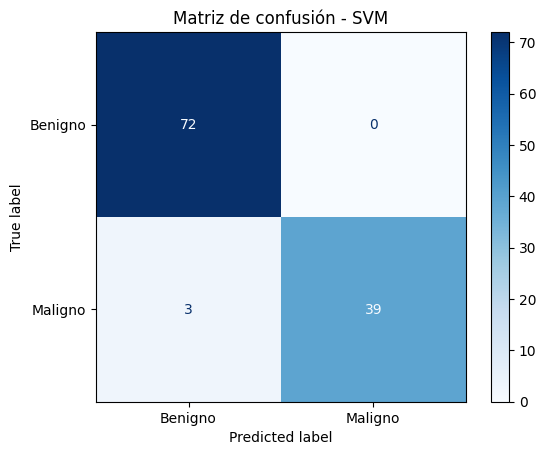

In [15]:
# ====================================
# 7) Evaluación en test
# ====================================
y_pred = best_model.predict(X_test)
print("\nReporte de clasificación (TEST):\n")
print(classification_report(y_test, y_pred, target_names=["Benigno(0)","Maligno(1)"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benigno","Maligno"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Matriz de confusión - SVM")
plt.show()


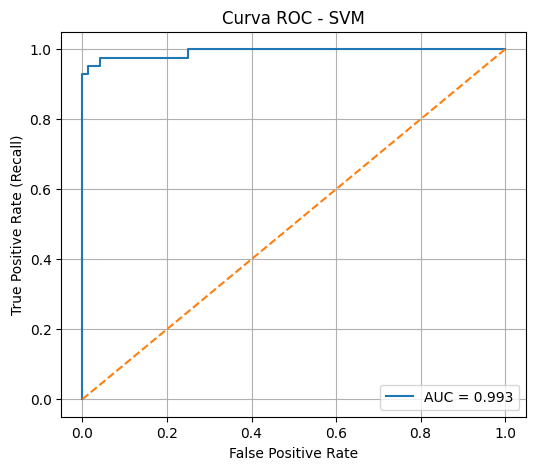

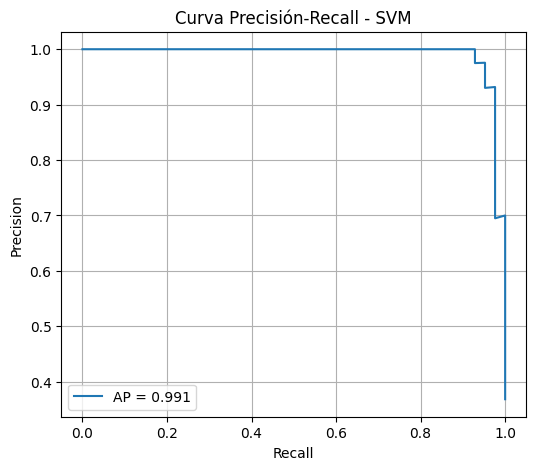

In [16]:
# ====================================
# 8) Curvas ROC y Precisión-Recall
# ====================================
y_score = best_model.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precisión-Recall - SVM")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()